In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# from exp.nb_Callbacks import *

In [3]:
from exp.nb_Earlystop import *

In [4]:
from pathlib import Path
import gzip
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

from functools import partial
import math
import re

# Path, data, dataset, dataloader and databunch

In [6]:
home_dir = Path('.').resolve()
data_dir = home_dir/'data'
file_dir = data_dir/'mnist.pkl.gz'

file_dir

PosixPath('/Users/xianli/Desktop/fast/Part2/data/mnist.pkl.gz')

In [7]:
# MNIST_url = 'http://deeplearning.net/data/mnist/mnist.pkl'

In [8]:
with gzip.open(file_dir, 'rb') as f:
    (x_train, y_train), (x_valid, y_valid), _ = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([50000, 784]),
 torch.Size([50000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

### Data normalization

In [9]:
def normalize_to(train, valid):
    m, s = train.mean(), train.std()
    return (train-m)/s, (valid-m)/s

x_train, x_valid = normalize_to(x_train, x_valid)

In [10]:
x_train.mean(), x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [11]:
class myDataset():
    def __init__(self,x,y):
        self.x, self.y = x, y
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self,i):
        return self.x[i], self.y[i]

In [12]:
def get_dls(ds_train, ds_valid, bs, **kwargs):
    return DataLoader(ds_train, bs, shuffle=True, **kwargs), DataLoader(ds_valid, bs, shuffle=False, **kwargs)

In [13]:
ds_train, ds_valid = myDataset(x_train,y_train), myDataset(x_valid,y_valid)

In [14]:
bs=512

In [15]:
class DataBunch():
    def __init__(self, dl_train,dl_valid, c_out = None):
        self.dl_train = dl_train
        self.dl_valid = dl_valid
        self.c_out = c_out
    @property
    def train_ds(self):
        return self.dl_train.dataset
    @property
    def valid_ds(self):
        return self.dl_valid.dataset

In [16]:
data = DataBunch(*get_dls(ds_train,ds_valid, bs),c_out=10)

In [17]:
len(data.train_ds), len(data.valid_ds)

(50000, 10000)

# Basic CNN

In [18]:
class Lambda(nn.Module): # Lambda layer
    def __init__(self, f):
        super().__init__()
        self.f = f
    def forward(self, x):
        return self.f(x)

In [19]:
def flatten(x):
    return x.view(x.shape[0],-1)
def resize_mnist(x): # MNIST is 784, resize to (N,color channel, H, W)
    return x.view(-1,1,28,28)

In [20]:
def get_cnn_model(data): # this only defines the model function, no need to put in any concrete data
    # here "data" DataBunch only intends to decide the output classes
    return nn.Sequential(
        Lambda(resize_mnist), # input layer
        nn.Conv2d(1, 8, 5, stride=2, padding=2), # size 14
        nn.ReLU(),
        nn.Conv2d(8, 16, 3, stride=2, padding=1), # 7
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2,padding=1), # 4
        nn.ReLU(),
        nn.Conv2d(32, 32, 3, stride=2, padding=1), # 2
        nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32, data.c_out) # collapse all channel together to one dim
    )

In [21]:
model = get_cnn_model(data) # this way model will only initialize once, weight will not change
# opt = optim.SGD(model.parameters(), lr = 0.4)
loss_func = F.cross_entropy

In [22]:
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

In [23]:
def get_model(data, lr=0.5):
    model = get_cnn_model(data)
    opt = optim.SGD(model.parameters(), lr = lr)
    return model, opt

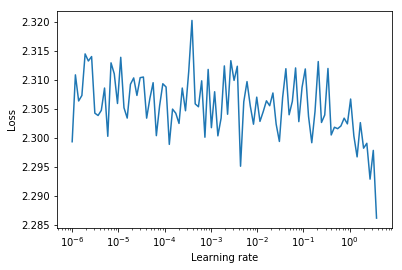

In [24]:
lr_find_cbf = [Recorder, LR_Finder]
lrfind_obj = Learner(*get_model(data), loss_func, data, cb_classes=lr_find_cbf)
lrfind_obj.fit(2)
lrfind_obj.recorder.plot(skip_last=3)

In [25]:
# this is working now
cb_funcs = [Recorder, 
            partial(AvgStatsCallback, accuracy)]
# cb_funcs += [partial(TestRunCallback,10,True,False)] # use for testing (i.e. run only a few batches)
learner = Learner(*get_model(data,lr=0.2), loss_func, data, cb_classes=cb_funcs)
%time learner.fit(1)

train: ['loss = 2.276683125', 'accuracy = tensor(0.1689)']
valid: ['loss = 1.895832421875', 'accuracy = tensor(0.5129)']
CPU times: user 7.19 s, sys: 1.46 s, total: 8.65 s
Wall time: 3.28 s


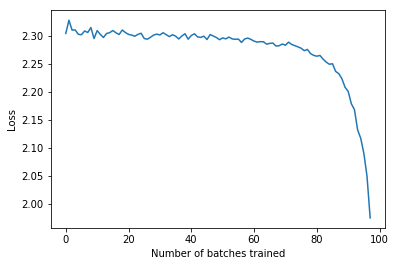

In [26]:
learner.recorder.plot_loss()

# Refactor CNN layer

In [27]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [28]:
# does data transform via callback
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.runner.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [29]:
# so that input layer transform can be removed if we do this
# mnist_view = view_tfm(1,28,28)
# cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [30]:
nfs = [8,16,32,32] # number of output channels (filters) at each layer except input

In [31]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs # add input layer
    input_layer = [Lambda(resize_mnist)]
    conv_layers = [conv2d(nfs[i], nfs[i+1], ks=5 if i==0 else 3) for i in range(len(nfs)-1)]
    output_layers = [ nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c_out)]
    return input_layer + conv_layers + output_layers

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data,nfs))

def get_learner(nfs, loss_func, data, lr=0.5, cb_objs = None, cb_classes=None):
    model = get_cnn_model(data,nfs)
    opt = optim.SGD(model.parameters(), lr)
    return (Learner(model, opt, loss_func, data, cb_objs, cb_classes), model)

In [32]:
cb_funcs = [Recorder, 
            partial(AvgStatsCallback, accuracy)]
# cb_funcs += [partial(TestRunCallback,10,True,False)] # use for testing (i.e. run only a few batches)
learner, model = get_learner(nfs, loss_func, data, lr=0.5, cb_classes=cb_funcs)
model

Sequential(
  (0): Lambda()
  (1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (5): AdaptiveAvgPool2d(output_size=1)
  (6): Lambda()
  (7): Linear(in_features=32, out_features=10, bias=True)
)

In [33]:
learner.fit(5)

train: ['loss = 2.29580765625', 'accuracy = tensor(0.1503)']
valid: ['loss = 2.210140625', 'accuracy = tensor(0.1820)']
train: ['loss = 1.5202446875', 'accuracy = tensor(0.4852)']
valid: ['loss = 0.423976171875', 'accuracy = tensor(0.8677)']
train: ['loss = 0.3462575390625', 'accuracy = tensor(0.8939)']
valid: ['loss = 0.20493701171875', 'accuracy = tensor(0.9381)']
train: ['loss = 0.19067810546875', 'accuracy = tensor(0.9429)']
valid: ['loss = 4.546594921875', 'accuracy = tensor(0.3175)']
train: ['loss = 0.59586859375', 'accuracy = tensor(0.8227)']
valid: ['loss = 0.2186030517578125', 'accuracy = tensor(0.9355)']


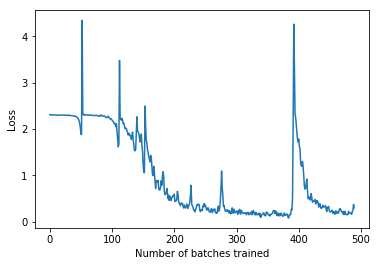

In [34]:
learner.recorder.plot_loss()

# Hooks

## 1. manual insertion

In [51]:
class ManualSequentialHook(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_mean = [[] for _ in layers] # initialize container of mean activations for each layer
        self.act_std =  [[] for _ in layers]
        
    def __call__(self, x):
        for i, l in enumerate(self.layers):
            x = l(x) # sequential model
            self.act_mean[i].append(x.data.mean()) # why use .data???
            self.act_std[i].append(x.data.std())
        return x
    
    def __iter__(self):
        return iter(self.layers)

In [54]:
lr =0.5
model = ManualSequentialHook(*get_cnn_layers(data, nfs))
opt = optim.SGD(model.parameters(), lr)
learner = Learner(model, opt, loss_func, data, cb_classes=cb_funcs)
learner.fit(3)

train: ['loss = 1.87382234375', 'accuracy = tensor(0.3602)']
valid: ['loss = 1.2014541015625', 'accuracy = tensor(0.6661)']
train: ['loss = 0.347583984375', 'accuracy = tensor(0.8956)']
valid: ['loss = 0.18678951416015624', 'accuracy = tensor(0.9447)']
train: ['loss = 0.16273666015625', 'accuracy = tensor(0.9512)']
valid: ['loss = 0.126258251953125', 'accuracy = tensor(0.9615)']


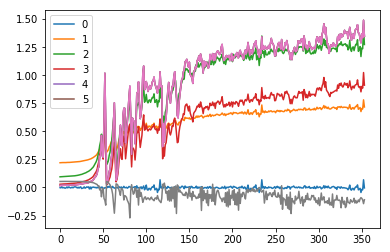

In [57]:
for l in model.act_mean: plt.plot(l)
plt.legend(range(6));

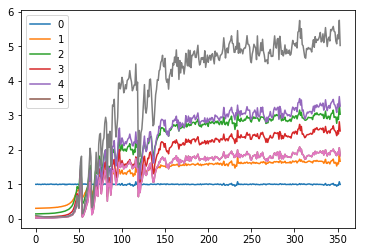

In [58]:
# std explodes and collapses, significantly deviate from 1
for l in model.act_std: plt.plot(l)
plt.legend(range(6));

## 2. Pytorch hooks
- Hooks don't require us to rewrite the model.
- A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output.
- there are forward hooks and backward hooks

### (1) Basic hook usage

In [69]:
# write your training as normal
lr = 0.5
model = get_cnn_model(data, nfs)
opt = optim.SGD(model.parameters(), lr)
learner = Learner(model, opt, loss_func, data, cb_classes=cb_funcs)

In [70]:
# container to save results
act_means = [[] for _ in model]
act_stds = [[] for _ in model]

def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds[i].append(outp.data.std())

In [71]:
# register hooks
for i, l in enumerate(model):
    l.register_forward_hook(partial(append_stats,i))

In [72]:
learner.fit(3)

train: ['loss = 2.0108278125', 'accuracy = tensor(0.2742)']
valid: ['loss = 0.749545703125', 'accuracy = tensor(0.7580)']
train: ['loss = 0.47693765625', 'accuracy = tensor(0.8482)']
valid: ['loss = 0.19088485107421874', 'accuracy = tensor(0.9426)']
train: ['loss = 0.23948837890625', 'accuracy = tensor(0.9281)']
valid: ['loss = 0.13710146484375', 'accuracy = tensor(0.9574)']


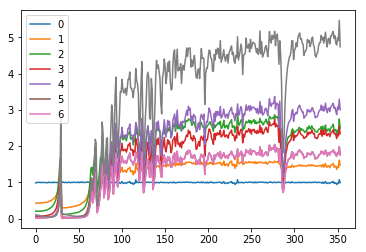

In [74]:
for l in act_stds:
    plt.plot(l)
plt.legend(range(7))

### (2) hook class
- basic hook usage doesn't remove the hooks from memory after usage. There will be references kept and the memory won't be properly released when your model is deleted.

In [75]:
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [76]:
lr = 0.5
model = get_cnn_model(data, nfs)
opt = optim.SGD(model.parameters(), lr)
learner = Learner(model, opt, loss_func, data, cb_classes=cb_funcs)

In [77]:
hooks = [Hook(l, append_stats) for l in list(model[:4].children())] # one hook object for each of the first 4 layers

In [78]:
learner.fit(2)

train: ['loss = 2.29913453125', 'accuracy = tensor(0.1654)']
valid: ['loss = 2.210758203125', 'accuracy = tensor(0.2405)']
train: ['loss = 1.193206875', 'accuracy = tensor(0.6076)']
valid: ['loss = 0.386457958984375', 'accuracy = tensor(0.8768)']


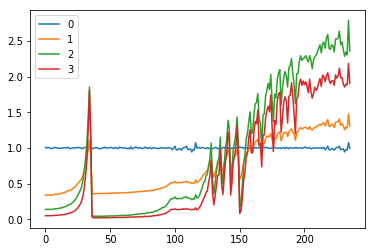

In [81]:
for h in hooks:
    plt.plot(h.stats[1]) # std
    h.remove()
plt.legend(range(4))

### 3. Better hook class
- automatically register a hook for each layer, i.e. contains several hooks
- allow several stats together

Hook class will use a container class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:
- a single index
- a slice (like 1:5)
- a list of indices
- a mask of indices (`[True,False,False,True,...]`)

In [2]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [3]:
#test
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

NameError: name 'listify' is not defined

In [86]:
#export
class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
        
class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove()
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [87]:
# this is an usage example
#export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [88]:
lr = 0.5
model = get_cnn_model(data, nfs)
opt = optim.SGD(model.parameters(), lr)
learner = Learner(model, opt, loss_func, data, cb_classes=cb_funcs)

In [89]:
# run with hooks
with Hooks(model, append_stats) as hooks:
    learner.fit(2)

train: ['loss = 1.9171078125', 'accuracy = tensor(0.3040)']
valid: ['loss = 1.33784814453125', 'accuracy = tensor(0.6263)']
train: ['loss = 0.446921875', 'accuracy = tensor(0.8534)']
valid: ['loss = 0.1865023681640625', 'accuracy = tensor(0.9438)']


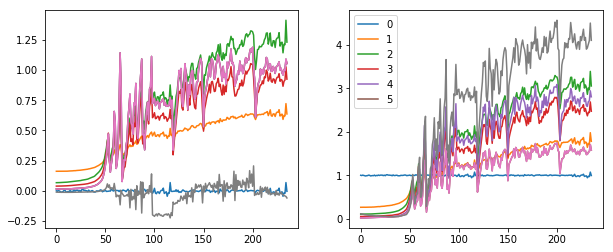

In [92]:
# plot mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
    ax0.plot(h.stats[0]) # mean
    ax1.plot(h.stats[1]) # std
plt.legend(range(6))

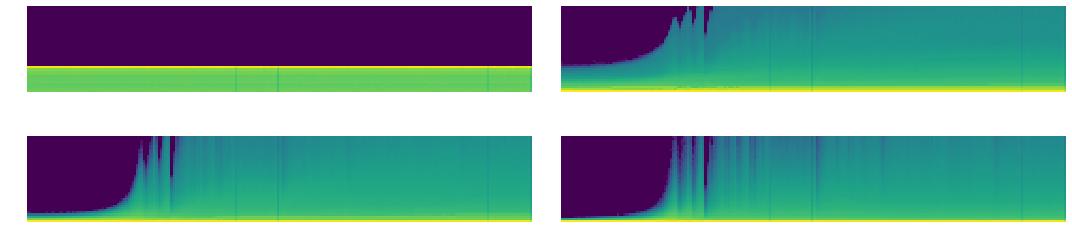

In [99]:
# plot histogram of activations
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()
fig,axes = plt.subplots(2,2, figsize=(15,4))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

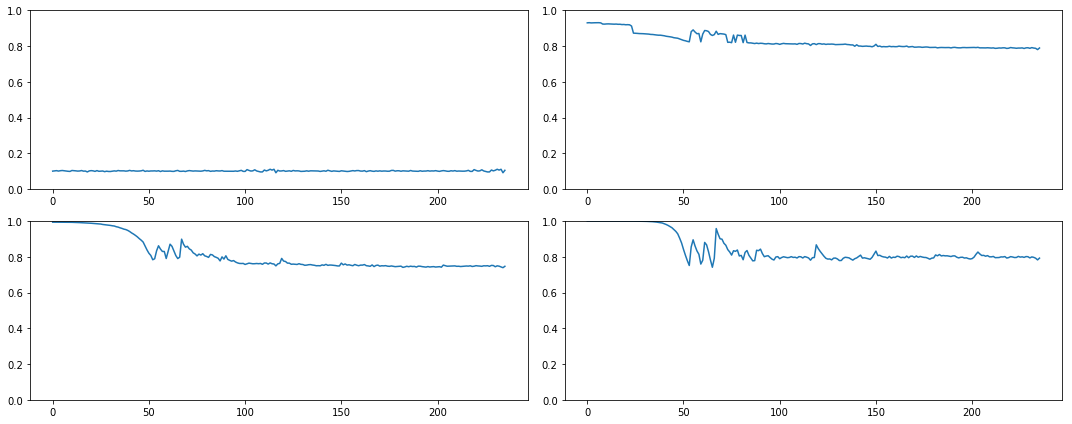

In [101]:
# min of the activations

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

# Modify conv initialization

In [103]:
from torch.nn import init

In [104]:
def init_cnn(m, uniform=False): # change to kaiming init
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

In [ ]:
lr = 0.5
model = get_cnn_model(data, nfs)
init_cnn(model)
opt = optim.SGD(model.parameters(), lr)
learner = Learner(model, opt, loss_func, data, cb_classes=cb_funcs)

In [105]:
with Hooks(model, append_stats) as hooks:
    learner.fit(2)

train: ['loss = 0.168532578125', 'accuracy = tensor(0.9472)']
valid: ['loss = 0.160938037109375', 'accuracy = tensor(0.9470)']
train: ['loss = 0.118218701171875', 'accuracy = tensor(0.9629)']
valid: ['loss = 0.1256970947265625', 'accuracy = tensor(0.9613)']


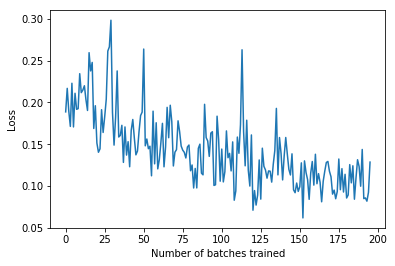

In [106]:
learner.recorder.plot_loss()

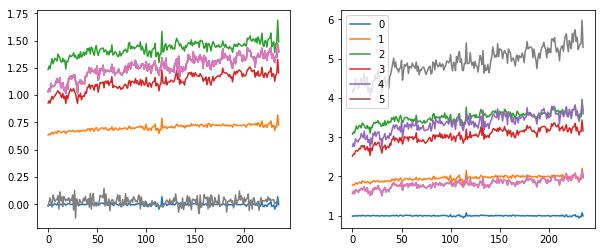

In [107]:
# plot mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
    ax0.plot(h.stats[0]) # mean
    ax1.plot(h.stats[1]) # std
plt.legend(range(6))

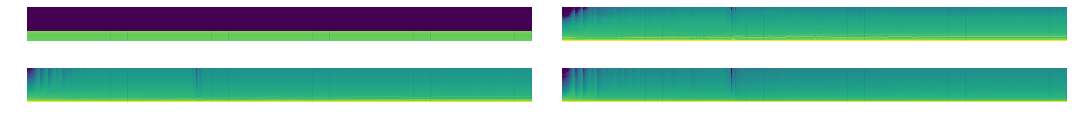

In [122]:
# plot histogram of activations
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()
fig,axes = plt.subplots(2,2, figsize=(15,2))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

# With one-cycle fit

In [109]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2,1.), sched_cos(1.,0.1)])
cb_funcs = [Recorder, 
            partial(ParamScheduler,'lr',sched),
            partial(AvgStatsCallback, accuracy)]

In [110]:
lr = 0.5
model = get_cnn_model(data, nfs)
init_cnn(model)
opt = optim.SGD(model.parameters(), lr)
learner = Learner(model, opt, loss_func, data, cb_classes=cb_funcs)

In [111]:
with Hooks(model, append_stats) as hooks:
    learner.fit(5)

train: ['loss = 1.165631328125', 'accuracy = tensor(0.6387)']
valid: ['loss = 0.55700390625', 'accuracy = tensor(0.8180)']
train: ['loss = 0.4312814453125', 'accuracy = tensor(0.8675)']
valid: ['loss = 0.205938134765625', 'accuracy = tensor(0.9411)']
train: ['loss = 0.152727392578125', 'accuracy = tensor(0.9520)']
valid: ['loss = 0.1695415283203125', 'accuracy = tensor(0.9488)']
train: ['loss = 0.08516384765625', 'accuracy = tensor(0.9737)']
valid: ['loss = 0.07594052734375', 'accuracy = tensor(0.9775)']
train: ['loss = 0.0600631396484375', 'accuracy = tensor(0.9820)']
valid: ['loss = 0.07242235107421875', 'accuracy = tensor(0.9785)']


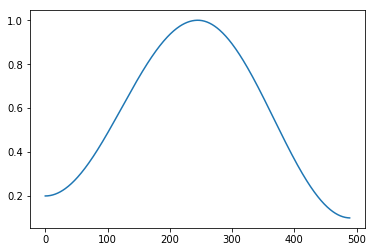

In [112]:
learner.recorder.plot_lr()

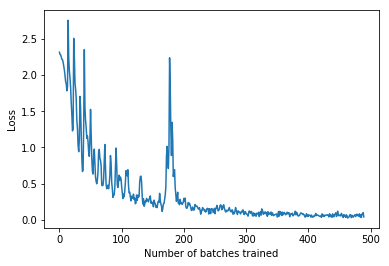

In [113]:
learner.recorder.plot_loss()

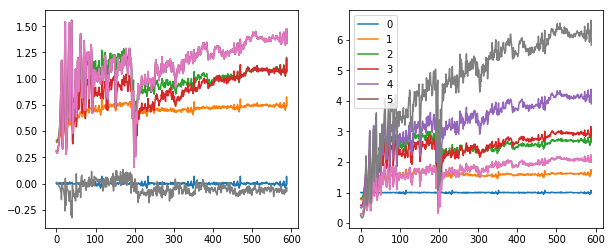

In [114]:
# plot mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
    ax0.plot(h.stats[0]) # mean
    ax1.plot(h.stats[1]) # std
plt.legend(range(6))

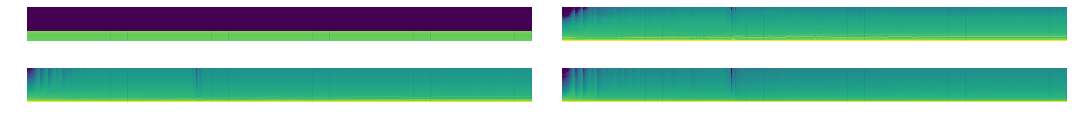

In [123]:
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()
fig,axes = plt.subplots(2,2, figsize=(15,2))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

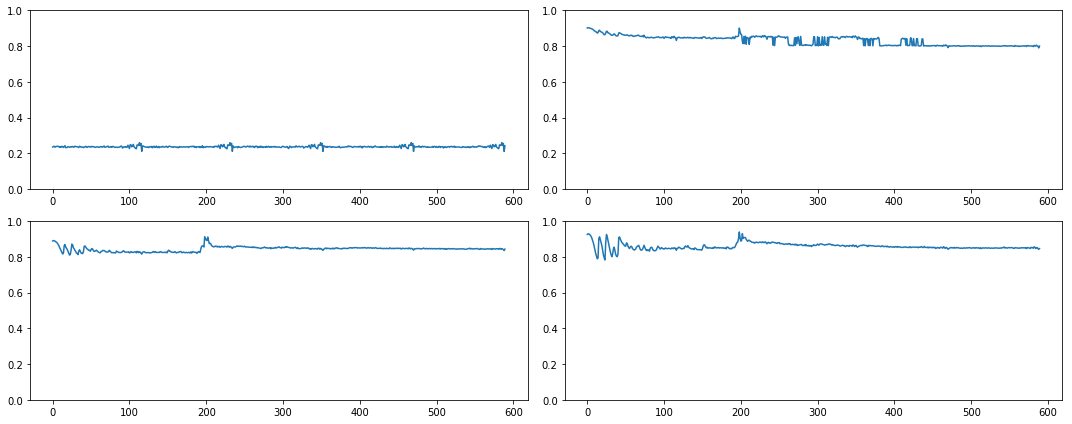

In [125]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:5].sum(0)/h1.sum(0)
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

# Generalized ReLU

In [ ]:
class GeneralRelu(nn.Module): # to replace nn.ReLU
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x